In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from collections import defaultdict
from tqdm import tqdm

# Read the dataset

In [ ]:
annotations_dir = '/content/drive/MyDrive/ObjectDetection/Annotations'
images_dir = '/content/drive/MyDrive/ObjectDetection/JPEGImages'

img_lst = []        # Chứa list các ảnh đọc bằng opencv
label_lst = []      # Chứa list các labels
classnames = []     # Chứa list các classname
images_labels = []  # Chứa list [image_name, bounding box, classname] trong ảnh
count = 0
for xml_file in tqdm(os.listdir(annotations_dir)[:1000]):
    xml_filepath = os.path.join(annotations_dir, xml_file)
    tree = ET.parse(xml_filepath)
    root = tree.getroot()

    folder = root.find('folder').text
    image_filename = root.find('filename').text
    img_filepath = os.path.join(images_dir, image_filename)
    img = cv2.imread(img_filepath)
    # List chứa các ảnh đã đọc
    img_lst.append([image_filename, img])

    image_bboxs = []
    for obj in tree.findall('object'):
        classname = obj.find('name').text
        if(classname not in classnames):
            classnames.append(classname)

        x_min = int(obj.find('bndbox/xmin').text)
        y_min = int(obj.find('bndbox/ymin').text)
        x_max = int(obj.find('bndbox/xmax').text)
        y_max = int(obj.find('bndbox/ymax').text)
        image_bboxs.append([classname, [x_min, y_min, x_max, y_max]])

    images_labels.append([image_filename, image_bboxs])

100%|██████████| 1000/1000 [00:38<00:00, 26.11it/s]


In [ ]:
print(f"length of dataset: {len(img_lst)}")

length of dataset: 1000


In [ ]:
print(f"Number of class: {len(classnames)}")
print(f"Classnames: {classnames}")

Number of class: 20
Classnames: ['car', 'person', 'sofa', 'bottle', 'tvmonitor', 'cat', 'chair', 'motorbike', 'pottedplant', 'sheep', 'diningtable', 'horse', 'dog', 'boat', 'bus', 'aeroplane', 'train', 'bicycle', 'cow', 'bird']


In [ ]:
images_labels[2]

['000559.jpg',
 [['bottle', [36, 250, 79, 354]], ['tvmonitor', [160, 26, 371, 241]]]]

In [ ]:
dataset_dict = {}

for i in range(len(images_labels)):
    images_labels[i].append(img_lst[i][1])

In [ ]:
images_labels[0]

['000541.jpg',
 [['car', [113, 195, 150, 213]],
  ['car', [224, 193, 268, 208]],
  ['car', [237, 194, 272, 212]],
  ['car', [248, 196, 287, 214]],
  ['car', [259, 194, 335, 219]],
  ['car', [95, 191, 124, 195]],
  ['car', [79, 202, 156, 221]],
  ['person', [155, 205, 169, 222]]],
 array([[[168, 175, 168],
         [197, 202, 193],
         [221, 222, 212],
         ...,
         [171, 148,  98],
         [163, 147, 105],
         [137, 124,  86]],
 
        [[ 15,  20,  18],
         [ 47,  53,  48],
         [ 90,  92,  86],
         ...,
         [124, 115,  72],
         [ 70,  64,  29],
         [ 53,  50,  19]],
 
        [[  6,  11,  14],
         [  9,  14,  15],
         [  4,   9,   8],
         ...,
         [ 76,  90,  66],
         [ 69,  86,  65],
         [ 42,  61,  42]],
 
        ...,
 
        [[ 16,  59,  78],
         [ 49,  92, 113],
         [ 28,  68,  93],
         ...,
         [ 55,  95,  77],
         [ 48,  87,  71],
         [ 62, 101,  86]],
 
        [[ 2

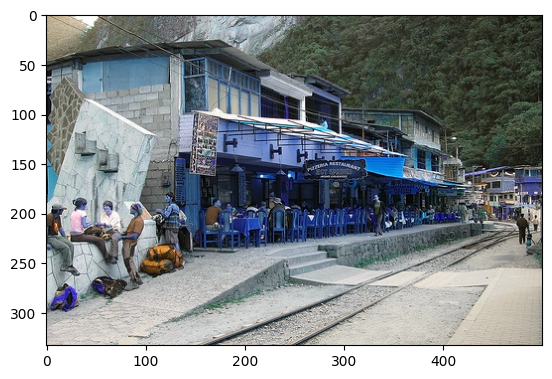

In [ ]:
plt.imshow(img_lst[10][1])

# Preprocessing

In [ ]:
#.....

# Load the dataset

In [ ]:
images_labels[0][1][2][1], images_labels[0][2].shape

([237, 194, 272, 212], (333, 500, 3))

In [ ]:
import sys
import os

# Get the current directory of the notebook
current_dir = os.getcwd()

# Add the parent directory to the search path
path = '/content/drive/MyDrive/'
utils_dir = os.path.join(path, 'ObjectDetection')
print(utils_dir)
sys.path.append(utils_dir)

from utils import *
from model import *

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize

/content/drive/MyDrive/ObjectDetection


In [ ]:
le = LabelEncoder()
labels_encode = le.fit_transform(classnames)
le.transform(['chair'])[0]

8

In [ ]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]

    def get_data(self):
        img_data_all = []
        gt_bboxes_all = []
        gt_labels_all = []
        le = LabelEncoder()
        labels_encoded = le.fit_transform(classnames)

        for i in tqdm(range(len(self.dataset))):
            original_img_size = self.dataset[i][2].shape[:2]
            image = resize(self.dataset[i][2], (480, 640))
            img_tensor = torch.from_numpy(image).permute(2, 0, 1)
            img_data_all.append(img_tensor)

            # encode classname
            labels_gt = []
            bboxes_gt = []
            for j in range(len(self.dataset[i][1])):
                labels_gt.append(le.transform([self.dataset[i][1][j][0]])[0])
                bboxes_gt.append(self.dataset[i][1][j][1] * np.array([480/original_img_size[0], 640/original_img_size[1], 480/original_img_size[0], 640/original_img_size[1]]))

            # Convert bounding boxes to tensors before appending
            gt_bboxes_all.append(torch.tensor(bboxes_gt, dtype=torch.float32)) # Convert to tensor here
            gt_labels_all.append(torch.tensor(labels_gt, dtype=torch.int64))   # Convert to tensor here

        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = pad_sequence(gt_bboxes_all, batch_first=True, padding_value=-1)
        gt_classes_pad = pad_sequence(gt_labels_all, batch_first=True, padding_value=-1)
        img_data_stacked = torch.stack(img_data_all, dim=0)

        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad

 Dataloader

In [ ]:
dataset = ObjectDetectionDataset(images_labels[:500])
dataloader = DataLoader(dataset=dataset, batch_size=2, shuffle=True)

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-14-0cc655ab9f3f>:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  gt_bboxes_all.append(torch.tensor(bboxes_gt, dtype=torch.float32)) # Convert to tensor here
100%|██████████| 500/500 [00:44<00:00, 11.26it/s]


In [ ]:
testset = ObjectDetectionDataset(images_labels[500:600])
testloader = DataLoader(dataset=testset, batch_size=2, shuffle=True)

100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


In [ ]:
img_batch, gt_bboxes_batch, gt_classes_batch = next(iter(dataloader))

In [ ]:
img_batch.shape, gt_bboxes_batch.shape, gt_classes_batch.shape

(torch.Size([2, 3, 480, 640]), torch.Size([2, 37, 4]), torch.Size([2, 37]))

Visualize some samples

In [ ]:
def display_img(img_data, fig, axes):
    for i, img in enumerate(img_data):
        if type(img) == torch.Tensor:
            img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)

    return fig, axes

def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
    if type(bboxes) == np.ndarray:
        bboxes = torch.from_numpy(bboxes)
    if classes is not None and len(classes) > 0:
        assert len(bboxes) == len(classes)
    # convert boxes to xywh format
    bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    c = 0
    for box in bboxes:
        x, y, w, h = box.numpy()
        # display bounding box
        rect = patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # display category
        if classes is not None and c < len(classes):
        #     ax.text(x, y, classes[c], bbox=dict(facecolor='yellow', alpha=0.5))
        # elif classes is not None:
            if classes[c] == 'pad':
                continue
            ax.text(x + 5, y + 20, classes[c], bbox=dict(facecolor='yellow', alpha=0.5))
        c += 1

    return fig, ax

[tensor(14), tensor(14), tensor(14)]
[tensor(14), tensor(14), tensor(14)]


torch.Size([37, 4])
['person' 'person' 'person']
(3,)


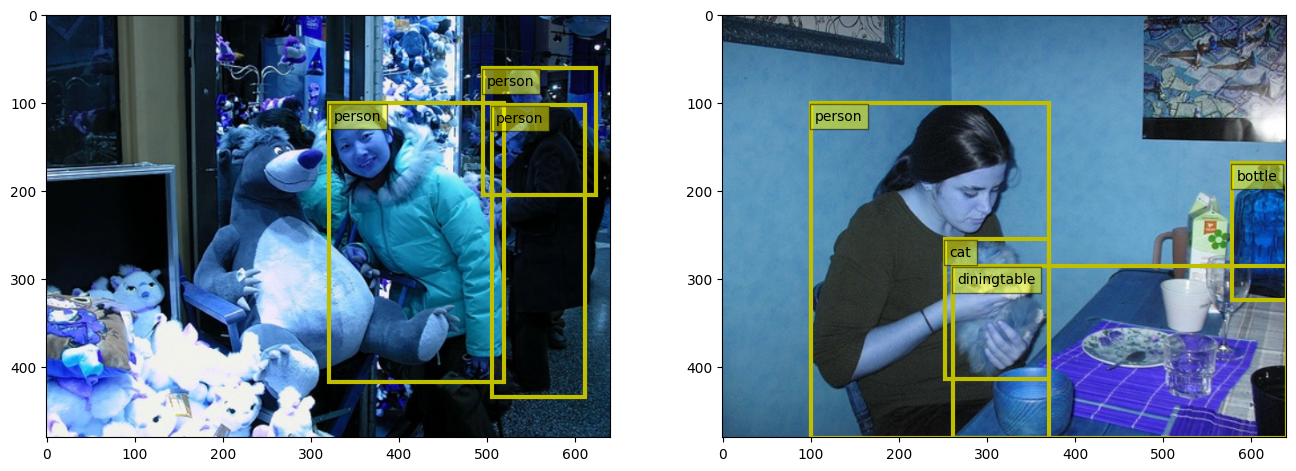

In [ ]:
for img_batch, gt_bboxes_batch, gt_classes_batch in dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break

img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_classes_all = gt_classes_all[:2]

# get class names
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = [gt_class_1[i] for i in range(len(gt_class_1)) if gt_class_1[i] != -1]
print(gt_class_1)
gt_class_1 = le.inverse_transform(gt_class_1)

# gt_class_1 = [idx2name[idx.item()] for idx in gt_class_1]

gt_class_2 = gt_classes_all[0].long()
gt_class_2 = [gt_class_2[i] for i in range(len(gt_class_1)) if gt_class_2[i] != -1]
print(gt_class_2)
gt_class_2 = le.inverse_transform(gt_class_2)

nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# Filter before pass into display_bbox
valid_indices_1 = [i for i, class_id in enumerate(gt_classes_all[0]) if class_id != -1]
filtered_bboxes_1 = gt_bboxes_all[0][valid_indices_1]
filtered_classes_1 = le.inverse_transform(gt_classes_all[0][valid_indices_1].long())


valid_indices_2 = [i for i, class_id in enumerate(gt_classes_all[1]) if class_id != -1]
filtered_bboxes_2 = gt_bboxes_all[1][valid_indices_2]
filtered_classes_2 = le.inverse_transform(gt_classes_all[1][valid_indices_2].long())

print("\n")
print(gt_bboxes_all[0].shape)
print(filtered_classes_1)
print(gt_class_1.shape)
fig, _ = display_bbox(filtered_bboxes_1, fig, axes[0], classes=filtered_classes_1)
fig, _ = display_bbox(filtered_bboxes_2, fig, axes[1], classes=filtered_classes_2)


# Building the model

Backbone network

In [ ]:
model = torchvision.models.resnet50(pretrained=True)

req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)

# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True

# run the image through the backbone
out = backbone(img_data_all)
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)
out_c, out_h, out_w

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(2048, 15, 20)

In [ ]:
img_size = (480, 640)
out_size = (out_h, out_w)
n_classes = len(classnames)  # exclude pad idx
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)

In [ ]:
detector.eval()
total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

tensor([[0.0463, 0.0478, 0.0341,  ..., 0.0346, 0.0421, 0.0516],
        [0.0457, 0.0476, 0.0332,  ..., 0.0339, 0.0329, 0.0442],
        [0.0571, 0.0518, 0.0447,  ..., 0.0401, 0.0472, 0.0494],
        ...,
        [0.0558, 0.0522, 0.0316,  ..., 0.0303, 0.0394, 0.0435],
        [0.0523, 0.0520, 0.0479,  ..., 0.0498, 0.0461, 0.0479],
        [0.0443, 0.0468, 0.0370,  ..., 0.0525, 0.0385, 0.0455]],
       grad_fn=<SoftmaxBackward0>)


In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# detector.to(device)

In [ ]:
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
detector.to(device)

def training_loop(model, learning_rate, train_dataloader, n_epochs):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    loss_list = []

    for i in range(n_epochs):
        total_loss = 0
        for j, (img_batch, gt_bboxes_batch, gt_classes_batch) in enumerate(train_dataloader):
            img_batch = img_batch.to(device)
            gt_bboxes_batch = gt_bboxes_batch.to(device)
            gt_classes_batch = gt_classes_batch.to(device)

            # forward pass
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        loss_list.append(total_loss)
        print(f"Epoch {i}/{n_epochs}: Training Loss: {total_loss/len(train_dataloader):.4f}")

    return loss_list

In [ ]:
learning_rate = 1e-3
n_epochs = 100

loss_list = training_loop(detector, learning_rate, dataloader, n_epochs)

In [ ]:
torch.save(detector.state_dict(), "/content/drive/MyDrive/ObjectDetection/model.pt")

In [ ]:
detector.load_state_dict(torch.load(f"/content/drive/MyDrive/ObjectDetection/model.pt", map_location=device))

<ipython-input-28-ee1f384b7209>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  detector.load_state_dict(torch.load(f"/content/drive/MyDrive/ObjectDetection/model.pt", map_

<All keys matched successfully>

# Inference

In [ ]:
for img_batch, gt_bboxes_batch, gt_classes_batch in testloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break

img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_classes_all = gt_classes_all[:2]
detector.eval()
proposals_final, conf_scores_final, classes_final = detector.inference(img_data_all, conf_thresh=0.8, nms_thresh=0.05)

print(classes_final)
print(f"gt_class: {gt_classes_all} ")
print(proposals_final)

# scalse factor
width_scale_factor = 640 / out_w
height_scale_factor = 480 / out_h

# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='f2p')
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='f2p')

print(prop_proj_1)
print(prop_proj_2)

# get classes
# classes_pred_1 = [le.inverse_transform(cls) for cls in classes_final[0].tolist()]
# classes_pred_2 = [le.inverse_transform(cls) for cls in classes_final[1].tolist()]
classes_pred_1 = le.inverse_transform(classes_final[0].cpu().numpy().reshape(-1,))
classes_pred_2 = le.inverse_transform(classes_final[1].cpu().numpy().reshape(-1,))

nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch, fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)